# Primeiro Trabalho - Random Walk (complemento)

- [0. Introdução](#0.-Introdução)
    - [0.1. PPSO](#0.1.-PPSO)
    - [0.2. Descrição da Tarefa](#0.2.-Descrição-da-Tarefa)
    - [0.3. Implementação](#0.3.-Implementação)
        - [0.3.1. Parâmetros](#0.3.1.-Parâmetros)
        - [0.3.2. Partícula](#0.3.2.-Partícula)
        - [0.3.3. Enxame](#0.3.3.-Enxame)
        - [0.3.4. Funções gerais](#0.3.4.-Funções-gerais)
- [1. Primeiro caso de teste](#1.-Primeiro-caso-de-teste)
    - [1.1. Implementação](#1.1.-Implementação)
    - [1.2. Execução](#1.2.-Execução)
    - [1.3. Resultados](#1.3.-Resultados)
        - [1.3.1. Tabela](#1.3.1.-Tabela)
        - [1.3.2. Gráfico de Convergência](#1.3.2.-Gráfico-de-Convergência)
- [2. Segundo caso de teste](#2.-Segundo-caso-de-teste)
    - [2.1. Implementação](#2.1.-Implementação)
    - [2.2. Execução](#2.2.-Execução)
    - [2.3. Resultados](#2.3.-Resultados)
        - [2.3.1. Tabela](#2.3.1.-Tabela)
        - [2.3.2. Gráfico de Convergência](#2.3.2.-Gráfico-de-Convergência)

# 0. Introdução

## 0.1. PPSO

## 0.2. Descrição da Tarefa

- Primeiro caso de teste

Considere a seguinte função objetivo:

$$ y = 10 (x1-1)^{2} + 20 (x2-2)^{2} + 30 (x3-3)^{2} $$

Desenvolver um Random Walk ou equivalente para achar o mínimo da função . Usando uma distribuição uniforme gere uma população de sequências de números reais variando de 0 a 1. Cara sequência terá três valores que são o x1, x2 e x3 da equação:

$$x_i' = LB_{x_i} + ( UB_{x_i}-LB_{x_i})*valor_i$$

Cada valor na sequência precisa ser convertido para a faixa de x1, x2 e x3.

- Segundo caso de teste

Reutilizar o Random walk desenvolvido para a tarefa anterior para encontrar a palavra descrita abaixo. Cada sequência aleatória do RW será uma palavra do mesmo tamanho da palavra alvo e a função fitness será uma medida de similaridade entre a sequência e a palavra alvo.

$$Alvo = \{52.547, 72.154, 53.694, 57.771, 115.88, 105.59, 75.368, 126.02, 52.756, 85.100, 80.525, 111.24, 113.62, 64.95, 89.181,\\
85.647, 101.71, 106.75, 110.37, 72.082, 104.38, 102.41, 63.009, 59.52, 89.869, 126.78, 77.231, 96.821, 67.905, 110.1\}$$

## 0.3. Implementação

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from PPSO.classes.Swarm import Swarm

In [2]:
class PSO:
    def __init__(self, f, NPARTICLE, DIM, RANGE, NITERATION, VMAX, C1, C2, WRANGE, W):
        self.swarm = Swarm(f, NPARTICLE)
        self.swarm.initialize()
        self.g = self.getGlobalBest(self.swarm)
        self.avg = np.zeros(NITERATION)
        self.std = np.zeros(NITERATION)
        self.bfit = np.zeros(NITERATION)
        self.bx = [[] for i in range(NITERATION)]
    
    # Update the velocity of a particle
    def updateVelocity(self, i, p, g):
        r1 = np.random.random(DIM)
        r2 = np.random.random(DIM)
        p.v = W[i] * p.v + \
              C1 * r1 * (p.m - p.x) + \
              C2 * r2 * (g.x - p.x)
        for i in range(DIM):
            if(np.abs(p.v[i]) > VMAX):
                p.v[i] = np.sign(p.v[i]) * VMAX        
    
    # Move a particle in the search space
    def move(self, p):
        p.x = p.x + p.v
        for i in range(DIM):
            if(p.x[i] < RANGE[0]):
                p.x[i] = RANGE[0]
            if(p.x[i] > RANGE[1]):
                p.x[i] = RANGE[1]

    # Evaluate a particle
    def evaluate(self, p):
        p.evaluate()

    # Update local and global best memories
    def updatePBAndGB(self, p, g):
        if(p.fit_x <= p.fit_m):
            p.m = copy.deepcopy(p.x)
            p.fit_m = p.fit_x
            if(p.fit_x <= g.fit_x):
                g.x = copy.deepcopy(p.x)
                g.fit_x = p.fit_x

    # Find the best particle from the swarm
    def getGlobalBest(self, swarm):
        fits = [p.fit_x for p in swarm.particles]
        i = fits.index(min(fits))
        return swarm.particles[i].getCopy()
    
    def run(self):
        for i in range(NITERATION):
            for j in range(NPARTICLE):
                self.updateVelocity(i, self.swarm.particles[j], self.g)
                self.move(self.swarm.particles[j])
                self.evaluate(self.swarm.particles[j])
                self.updatePBAndGB(self.swarm.particles[j], self.g)
            self.avg[i] = self.swarm.avgFitness()
            self.std[i] = self.swarm.stdFitness(self.avg[i])
            self.bfit[i] = self.g.fit_x
            self.bx[i] = self.g.x

In [3]:
class StatsHandler:
    def __init__(self, NRUN, f, NPARTICLE, DIM, RANGE, NITERATION, VMAX, C1, C2, WRANGE, W):
        self.NRUN = NRUN
        self.f = f
        results = self.execute(NPARTICLE, DIM, RANGE, NITERATION, VMAX, C1, C2, WRANGE, W)
        self.avg = results["avg"]
        self.std = results["std"]
        self.bestY = results["bestY"]
        self.bestG = results["bestG"]

    def execute(self, NPARTICLE, DIM, RANGE, NITERATION, VMAX, C1, C2, WRANGE, W):
        # list of lists containing the top 5 solutions by iteration
        bestY = [[] for i in range(NITERATION)]
        bestG = []

        for r in range(self.NRUN):
            p = PSO(self.f, NPARTICLE, DIM, RANGE, NITERATION, VMAX, C1, C2, WRANGE, W)
            p.run()
            for i in range(NITERATION):
                bestY[i].append(p.bfit[i])
            bestG.append(p.g)

        avg = [np.mean(i) for i in bestY]
        std = [np.std(i) for i in bestY]

        return {
            "avg": avg,
            "std": std,
            "bestY": bestY,
            "bestG": bestG
        }
    
    def get_table(self):
        df = pd.DataFrame()
        for g in self.bestG:
            dic = {f"r{i}": g.x[i] for i in range(len(g.x))}
            dic["y"] = str("{:.4e}".format(g.fit_x))
            df = df.append(dic, ignore_index=True)
        return df
    
    def plot_convergence(self):
        sns.set_style("dark")
        stats = pd.DataFrame(list(zip(self.avg, self.std)), columns=["mean", "std"])
        plt.figure(figsize=(20,10))
        plt.grid()
        plt.plot(stats.index, stats["mean"], label="Mean")
        plt.fill_between(range(len(stats)), stats["mean"]-stats["std"], stats["mean"]+stats["std"], alpha = 0.5, label="Std. Dev.")
        plt.plot(stats.index, [min(stats["mean"]) for i in range(len(stats.index))], label="Minimum")
        plt.xticks(np.arange(0, len(stats)+1, len(stats)/10))
        plt.xlabel("Iteration")
        plt.ylabel("Average fitness")
        plt.title("Average fitness by Iteration")
        plt.legend()
        plt.savefig("case1.png", dpi=300)
        plt.show()

# 1. Primeiro caso de teste

## 1.1. Implementação

In [4]:
def f(x):
    return 10*(x[0]-1)**2 + 20*(x[1]-2)**2 + 30*(x[2]-3)**2

## 1.2. Execução

In [5]:
NRUN = 5
f = f
NPARTICLE = 20
DIM = 3
RANGE = (-5, 5)
NITERATION = 500
VMAX = (RANGE[1] - RANGE[0]) / 2.0
C1 = 2.05
C2 = 2.05
WRANGE = (.4, .9)
W = [WRANGE[1] - (WRANGE[1] - WRANGE[0]) * i / NITERATION for i in range(NITERATION)]

s = StatsHandler(NRUN, f, NPARTICLE, DIM, RANGE, NITERATION, VMAX, C1, C2, WRANGE, W)

## 1.3. Resultados

### 1.3.1. Tabela

In [6]:
s.get_table()

,r0,r1,r2,y
0,1.0,2.0,3.0,1.4840e-28
1,1.0,2.0,3.0,1.4791e-30
2,1.0,2.0,3.0,1.3312e-29
3,1.0,2.0,3.0,2.7418e-27
4,1.0,2.0,3.0,4.9304e-31


### 1.3.2. Gráfico de Convergência

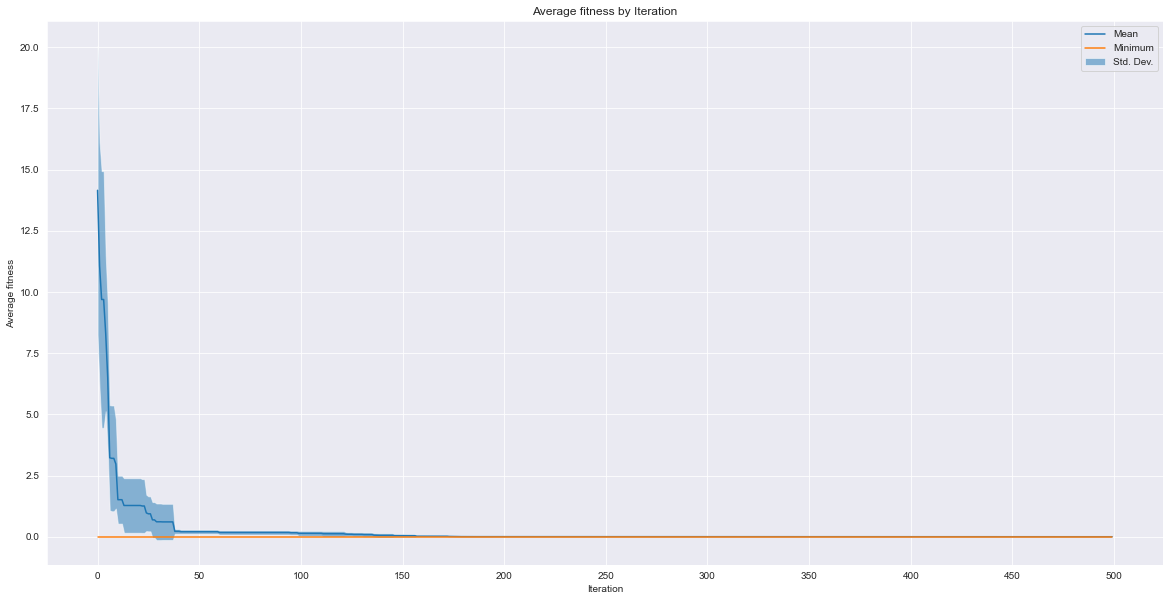

In [7]:
s.plot_convergence()

# 2. Segundo caso de teste

## 2.1. Implementação

In [8]:
target_word = [
    52.547, 72.154, 53.694, 57.771, 115.88, 105.59, 75.368, 126.02,
    52.756, 85.100, 80.525, 111.24, 113.62, 64.95, 89.181, 85.647,
    101.71, 106.75, 110.37, 72.082, 104.38, 102.41, 63.009, 59.52,
    89.869, 126.78, 77.231, 96.821, 67.905, 110.1
]

def f(word, target=target_word):
    return (sum([(target[i] - word[i])**2 for i in range(len(target))]))**.5

## 2.2. Execução

In [9]:
s = StatsHandler(
    NRUN = 5,
    f = f,
    NPARTICLE = 20,
    DIM = len(target_word),
    RANGE = (min(target_word), max(target_word)),
    NITERATION = 500,
    VMAX = (RANGE[1] - RANGE[0]) / 2.0,
    C1 = 2.05,
    C2 = 2.05,
    WRANGE = (.4, .9),
    W = [WRANGE[1] - (WRANGE[1] - WRANGE[0]) * i / NITERATION for i in range(NITERATION)]
)

IndexError: index 3 is out of bounds for axis 0 with size 3

## 2.3. Resultados

### 2.3.1. Tabela

In [ ]:
s.get_table()

### 2.3.2. Gráfico de Convergência

In [ ]:
s.plot_convergence()